## 시험 스크립트 2 : (스크립트1로) 모델 훈련 후에 저장했던 모델weight를 가지고 축소 모델 Shap Explainer 객체를 만들고 이를 활용해 악성종양 분류에의 기여도가 가장 큰 유전자 20개를 뽑은 다음, 이전 데이터셋에서 이 20개를 제외한 새로운 데이터셋을 만듦

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import torchinfo
device = T.device("cuda" if T.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
import shap
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000


## 2. Implementing backbone of Transformer-based Classifier

In [2]:
# feature 개수 확인 및 설정
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'r')
X = np.array(hf.get('X'))
Y = np.array(hf.get('Y'))
print('X.shape :', X.shape, ', X.dtype :', X.dtype)
print('Y.shape :', Y.shape, '     , Y.dtype :', Y.dtype)
hf.close()

n_feature = X.shape[1]
print("\nThe number of feature :", n_feature)

X.shape : (407, 1461) , X.dtype : float64
Y.shape : (407,)      , Y.dtype : int8

The number of feature : 1461


In [3]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.x_data = T.tensor(X, dtype=T.float32).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [4]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=n_feature):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = n_feature ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1501 -> 12008 -> Transformer -> FC -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # I input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # I input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # default 6 layers 
        # STAD Dataset has I input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = I input features, fixed length
        z = self.embed(x.int())  # I inputs to I*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # later followed by NLL Loss()
        return z
max_F1 = 0

### 3-1. Lodaing Dataset

In [6]:
# 0. setup
print("Making tensor dataset of STAD samples on device", device, T.cuda.get_device_name(0))
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset3_Train_exam.h5"
train_ds = STAD_Dataset(train_file)
print(" ", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset3_Test_exam.h5"
test_ds = STAD_Dataset(test_file)
print(" ", len(test_ds), "test dataset created from an h5 file")

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file


## 7. Analizing the degree of contribution of each feature using SHAP

#### 7-1. 트랜스포머 인코더 feature 번호가 어떤 유전자ID였는지 참조할 리스트 만들고 각 유전자ID에 해당하는 gene symbol 리스트 만들기

In [7]:
df_All = pd.read_pickle('xy_STAD-related-only3_exam_features_removed.pkl')
df_X = df_All.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
STAD_related_geneID_list = df_X.columns

df = pd.read_excel('GASCplusPHGDH_1554.xlsx')

STAD_related_gene_symbol_list = []
for gene_ID in STAD_related_geneID_list:
    for i, E_ID in enumerate(df['Ensembl ID']):
        if gene_ID == E_ID:
            STAD_related_gene_symbol_list.append(df['Gene Symbol'][i])
print("Length of the gene symbol list :", len(STAD_related_gene_symbol_list))

Length of the gene symbol list : 1461


### 7-2. Plotting shapley values using Gradient Explainer with transformer

In [8]:
# 훈련했던 모델 불러오기
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./exam.pt'))

<All keys matched successfully>

In [9]:
# 복잡한 트랜스포머 모델을 설명하기 위한 작은 축소 모델 만들기 
ge = shap.GradientExplainer((model, model.trans_enc), train_ds.x_data[:275])

In [10]:
# 축소모델로 shapley value 구하기
G_shap_values = ge.shap_values(train_ds.x_data[0:1])
len(G_shap_values), G_shap_values[3].shape, G_shap_values[3][0].shape, G_shap_values[3][0].T.shape

(4, (1, 1461, 8), (1461, 8), (8, 1461))

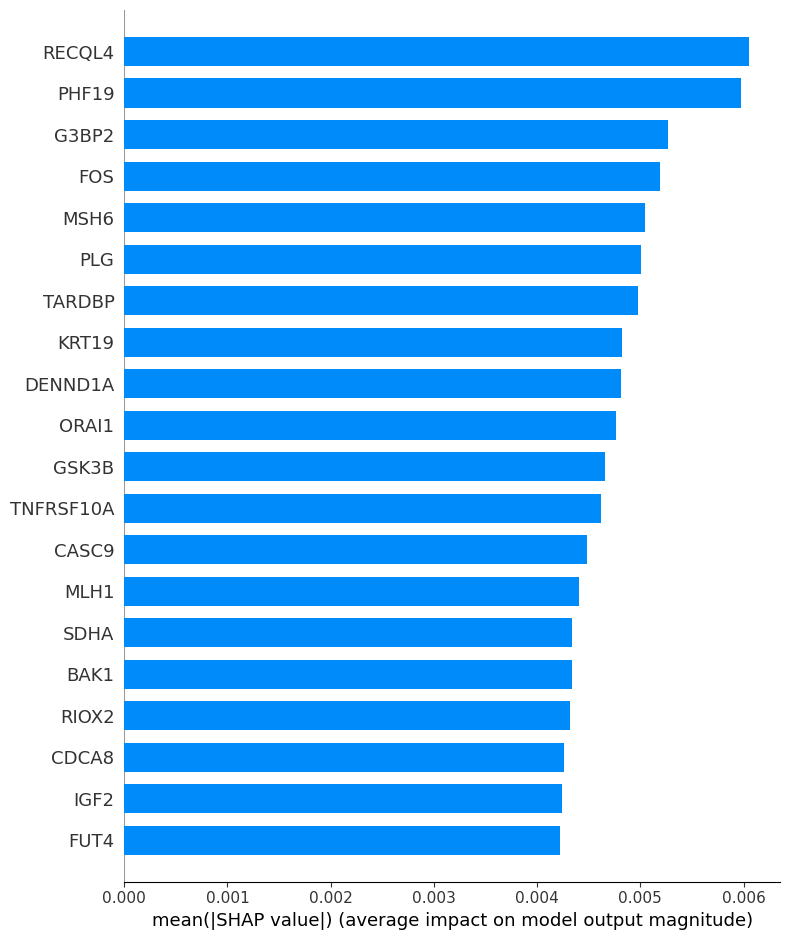

In [11]:
# Shapley value 로 각 feature 들의 (모델추론결과(분류)에의) 기여도(영향력) 그래프 그리기
shap.summary_plot(G_shap_values[3][0].T, plot_type='bar', features=STAD_related_gene_symbol_list)

##### 7-3. 악성종양 분류에의 기여도가 가장 큰 20개의 유전자를 뺀 데이터 파일 만들기 

In [12]:
# 위 그래프 상황 데이터프레임으로 재현
shap_df = pd.DataFrame(data=G_shap_values[3][0])
symbol_df = pd.DataFrame(data=STAD_related_gene_symbol_list)
symbol_shap_df = pd.concat([symbol_df, shap_df], axis=1)
mean_df = pd.DataFrame(np.mean(np.abs(G_shap_values[3][0]), axis=1))
symbol_shap_mean_df = pd.concat([symbol_shap_df, mean_df], axis=1)
symbol_shap_mean_df.columns=['G_symbol','head1','head2','head3','head4','head5','head6','head7','head8','abs_mean']
symbol_shap_mean_df_sorted = symbol_shap_mean_df.sort_values(by=['abs_mean'], ascending=[False])
symbol_shap_mean_df_sorted

,G_symbol,head1,head2,head3,head4,head5,head6,head7,head8,abs_mean
801,RECQL4,0.001185,-0.017233,-0.000494,-0.017928,-0.001304,0.004831,-0.000939,0.004483,0.006049
417,PHF19,-0.001914,0.012021,-0.002366,0.017526,-0.001237,0.005213,0.000116,-0.007434,0.005978
612,G3BP2,-0.002700,-0.007660,0.000481,0.016967,0.002052,-0.008464,0.000220,0.003569,0.005264
950,FOS,0.000068,0.011580,-0.000230,0.014795,0.004171,0.003129,0.000013,-0.007504,0.005186
384,MSH6,0.000795,-0.010160,0.000737,-0.009379,0.000069,-0.006773,-0.001361,0.011064,0.005042
...,...,...,...,...,...,...,...,...,...,...
732,SAP18,0.000043,-0.001110,0.000166,0.000582,0.000037,0.000434,0.000168,-0.001213,0.000469
709,AOPEP,0.000092,-0.000904,0.000017,-0.000437,0.000301,0.000432,0.000185,-0.000784,0.000394
1106,DPYD,0.000133,-0.000007,-0.000022,0.000108,-0.000045,-0.001546,0.000302,-0.000800,0.000370
248,GSR,-0.000449,0.000040,-0.000178,-0.000083,-0.000019,0.000128,-0.000115,0.000918,0.000241


In [13]:
# 상위 20개의 Gene symbol
symbol_shap_mean_df_sorted.iloc[0:20]['G_symbol']

801        RECQL4
417         PHF19
612         G3BP2
950           FOS
384          MSH6
441           PLG
431        TARDBP
965         KRT19
418       DENND1A
1442        ORAI1
147         GSK3B
249     TNFRSF10A
1380        CASC9
129          MLH1
116          SDHA
43           BAK1
960         RIOX2
551         CDCA8
898          IGF2
1119         FUT4
Name: G_symbol, dtype: object

In [14]:
# 상위 20개의 Gene symbol 에 해당하는 Ensenbl ID를 GASCplusPHGDH_1554 df 에서 찾아 리스트로 만들기  
ENSG_IDs_to_remove = []
for G in symbol_shap_mean_df_sorted.iloc[0:20]['G_symbol']:
    ENSG_IDs_to_remove.append(df[df['Gene Symbol']==G]['Ensembl ID'].to_string()[-15:])
ENSG_IDs_to_remove

['ENSG00000160957',
 'ENSG00000119403',
 'ENSG00000138757',
 'ENSG00000170345',
 'ENSG00000116062',
 'ENSG00000122194',
 'ENSG00000120948',
 'ENSG00000171345',
 'ENSG00000119522',
 'ENSG00000276045',
 'ENSG00000082701',
 'ENSG00000104689',
 'ENSG00000249395',
 'ENSG00000076242',
 'ENSG00000073578',
 'ENSG00000030110',
 'ENSG00000170854',
 'ENSG00000134690',
 'ENSG00000167244',
 'ENSG00000196371']

In [15]:
# 전체 데이터프레임으로부터 위 리스트의 요소가 컬럼이름인 데이터를 제거한 데이터프레임 만들기
df_All_features_removed = df_All.drop(labels=ENSG_IDs_to_remove, axis=1)
df_All_features_removed

,ENSG00000001036,ENSG00000001626,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000005007,ENSG00000005156,ENSG00000005175,ENSG00000005844,ENSG00000006327,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
318,20.219629,16.825263,19.121479,17.287974,16.630257,17.568893,15.572426,16.993762,15.244971,20.196295,...,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000,G1,TCGA-KB-A93H-01A
317,18.819095,12.144605,17.963353,16.261201,18.064107,18.698039,15.809532,16.613230,15.892170,19.542097,...,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656,G1,TCGA-KB-A93G-01A
132,19.807727,17.048517,19.515146,17.236227,16.513151,18.753454,16.319948,16.776418,15.494267,19.303977,...,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000,G1,TCGA-CD-5800-01A
179,18.941061,15.740072,19.171449,16.252021,17.308548,18.667955,15.786658,16.111774,16.296577,20.210354,...,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310,G1,TCGA-CG-5719-01A
258,19.919778,18.664863,18.456981,17.296716,16.551752,18.715583,16.050815,17.181970,13.915716,18.051995,...,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000,G1,TCGA-HU-8244-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,14.442284,18.851856,16.423086,17.029071,18.415530,16.069512,17.105799,15.877429,19.831597,...,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719,GX,TCGA-BR-8297-01A
378,20.160689,19.391947,17.841738,17.806221,17.092400,18.839794,16.161789,17.072886,16.660077,18.781345,...,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506,GX,TCGA-VQ-A91S-01A
344,19.631296,11.517487,18.765269,17.731691,17.073518,18.193675,15.092689,16.983539,15.178758,21.206392,...,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776,GX,TCGA-SW-A7EA-01A
50,19.331497,17.675182,18.370031,16.306453,17.176000,20.383370,15.860547,16.679588,14.489921,18.807122,...,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000,GX,TCGA-BR-7197-01A


In [16]:
# 최종 데이터프레임을 pickle 파일로 저장
df_All_features_removed.to_pickle('./xy_STAD-related-only3_exam_features_removed.pkl')

# Data Preprocessing for multi-class Classification in the domain of TCGA-STAD (The Cancer Genome Atlas Stomach Adenocarcinoma)

## 1. Making the final numpy dataset of XY values for inserting into model

### 1-1. Trim & Sort

In [17]:
# # xy_STAD-related-only3_exam_features_removed.pkl 파일을 처음으로 복구하는 코드 (만일 대비)
# df_init = pd.read_pickle('xy_STAD-related-only3_exam.pkl')
# df_init.to_pickle('./xy_STAD-related-only3_exam_features_removed.pkl')
# df_init.shape

### 1-2. Extracting dataset X & Y

In [18]:
# dfs2 = pd.read_pickle('xy_STAD-related-only3_exam.pkl')
dfs2 = pd.read_pickle('xy_STAD-related-only3_exam_features_removed.pkl')
df_X = dfs2.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
df_Y = dfs2[['neoplasm_histologic_grade']]
print('G1:  ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G1']))
print('G2: ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G2']))
print('G3: ', len(df_Y[df_Y['neoplasm_histologic_grade']=='G3']))
print('GX:   ', len(df_Y[df_Y['neoplasm_histologic_grade']=='GX']))
# NLL Loss 계산을 위해 label 차원은 2차원 행렬이 아닌 평범한 1차원 벡터가 되게 바꿈 
df_Y = dfs2['neoplasm_histologic_grade']


G1:   10
G2:  150
G3:  238
GX:    9


### 1-3. Converting data for deep learning model 

In [19]:
# X 데이터 : pandas dataframe 형식에서 numpy array 형식으로 변환
X = df_X.to_numpy(dtype='float64')
X.shape, X[0].dtype

((407, 1441), dtype('float64'))

In [20]:
# Y 데이터 : 문자에서 정수로 변환 G1->1, G2->2, G3->3, GX->0
Y = df_Y.replace({'G1':1, 'G2':2, 'G3':3, 'GX':0}).to_numpy(dtype='int8')
Y.shape, Y[0].dtype

((407,), dtype('int8'))

### 1-4. Min-Max Normalization for richer transformer embedding

In [21]:
def MinMax(X):
    X_norm = (X-np.min(X)) / (np.max(X)-np.min(X))
    return X_norm
X_norm = MinMax(X) * 319
X_norm

array([[206.81746899, 172.09803197, 195.58499015, ...,   0.        ,
        148.0143489 ,   0.        ],
       [192.49203866, 124.22168367, 183.73903337, ...,   0.        ,
        135.35931518,  90.02817139],
       [202.60430677, 174.38158934, 199.61163048, ...,   0.        ,
        168.82660949,   0.        ],
       ...,
       [200.79967061, 117.80718051, 191.94147886, ...,   0.        ,
        150.15699621, 110.31260635],
       [197.7331684 , 180.79146538, 187.89875863, ..., 100.18607087,
        152.22972238,   0.        ],
       [198.63190202, 183.38124043, 183.25383364, ..., 138.94816846,
        144.5793707 ,  87.02525398]])

### 1-5. Save dataset

In [22]:
# 2. 전체 X, Y 데이터셋 저장
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'w')
hf.create_dataset('X', data=X_norm)
hf.create_dataset('Y', data=Y)
hf.close()

### 1-6. Dataset Validation Check

In [23]:
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'r')
# hf.keys()
X = np.array(hf.get('X'))
Y = np.array(hf.get('Y'))

print('X.shape :', X.shape, X[0].dtype)
print('Y.shape :', Y.shape, Y[0].dtype)

hf.close()

X.shape : (407, 1441) float64
Y.shape : (407,) int8
